# Creating a realistic recording site from a rat cortex column

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pprint
np.set_printoptions(suppress=True)
from scipy.interpolate import interp1d
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
import math
from scipy.spatial.distance import squareform, pdist
from scipy.spatial import cKDTree
import pandas as pd
from collections import namedtuple

import os
import sys
module_path = os.path.abspath(os.path.join('/ERSS'))
if module_path not in sys.path:
    sys.path.append(module_path)

Channel = namedtuple("Channel", ["id", "pos", "type"])
Neuron = namedtuple("Neuron", ["id", "pos", "type", "layer"])
Layer = namedtuple("Layer", ["id", "name", "height", "volume", "total_count", "total_density", "in_ratio", 
                             "layer_density_distributions"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.  Building and visualizing a rat Somatosensory cortex column object

In [5]:
from regions.cortex.CortexColumn import Column
from regions.cortex.rat_cortex_data.CortexDataDicts import createHelmstaedterRatSomatosensoryCortexDataDict
#Random seed for reproducibility
np.random.seed(2)

#Import rat somatosensory cortex column dict from the Helmstaedter papers
rat_somatosensory_cortex_data_dict = createHelmstaedterRatSomatosensoryCortexDataDict()

'''
Create new column using the given cortex dict, a user defined radius, and a 
min distance (microns) enforced between neurons (takes a couple of minutes due to min_dist being set to 15)
'''
column = Column(rat_somatosensory_cortex_data_dict, radius=200.0, min_neuron_dist=15)

Building density/depth distributions...
... distributions built!
Building layers...
... layers built!
Filling layers with neurons...
...Filling layer L1 with 39 neurons...
...Filling layer L2 with 1924 neurons...
...Filling layer L3 with 2889 neurons...
...Filling layer L4 with 3149 neurons...
...Filling layer L5A with 1860 neurons...
...Filling layer L5B with 2055 neurons...
...Filling layer L6A with 3274 neurons...
...Filling layer L6B with 915 neurons...
... all layers filled!


In [6]:
#Layer information is stored in a layer DataFrame

print(column.getLayers())

   id region      height  radius    volume  neuron_count     density  \
0   0     L1   39.131288   200.0  0.004917            39    8.055457   
1   1     L2  205.445687   200.0  0.025817          1924   74.550935   
2   2     L3  240.326404   200.0  0.030200          2889   95.691451   
3   3     L4  196.777921   200.0  0.024728          3149  127.374160   
4   4    L5A  232.030661   200.0  0.029158          1860   63.798053   
5   5    L5B  272.754712   200.0  0.034275          2055   59.957850   
6   6    L6A  284.006800   200.0  0.035689          3274   91.763456   
7   7    L6B  193.046103   200.0  0.024259           915   37.751883   

    in_ratio                        layer_density_distributions  
0  84.118260  <scipy.stats._distn_infrastructure.rv_sample o...  
1  15.205110  <scipy.stats._distn_infrastructure.rv_sample o...  
2   8.034081  <scipy.stats._distn_infrastructure.rv_sample o...  
3   7.605610  <scipy.stats._distn_infrastructure.rv_sample o...  
4  24.717505  <scipy.

In [6]:
#Neuron information is stored in a neuron DataFrame

print(column.getNeurons())

          id                                                pos type layer
0          0  [-167.39462395708793, 92.38863001944779, 33.24...   IN    L1
1          1  [4.40203357897225, 167.21676618088128, 20.2644...   IN    L1
2          2  [23.289824031847605, 103.96064830105553, 5.690...   IN    L1
3          3  [-133.60495296478712, -41.47726151846803, 6.68...   IN    L1
4          4  [104.48427606761605, 6.738409016106275, 21.661...   IN    L1
5          5  [42.50603547548092, -4.51614414884634, 8.18562...   IN    L1
6          6  [189.54758179023364, 60.10076762272891, 33.940...   IN    L1
7          7  [66.37066662591694, 55.31745145151394, 35.2381...   IN    L1
8          8  [-105.16390079255432, 19.097207296615018, 38.9...   IN    L1
9          9  [55.06785832109499, -58.53369538645991, 32.942...   IN    L1
10        10  [146.31054127954135, -25.146405776261467, 33.7...   IN    L1
11        11  [-132.82712568202496, -3.3393797695706913, 14....   IN    L1
12        12  [-2.9776149

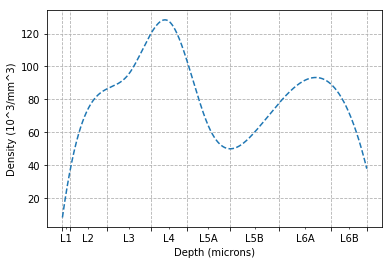

In [7]:
#Plot the density vs. depth distribution from which neurons were sampled

column.plotDensityDistribution()

Layer: L2
Radius: 200.0
Height: 205.44568697650476
Total Neurons: 1924
IN Neurons: 293
EX Neurons: 1631


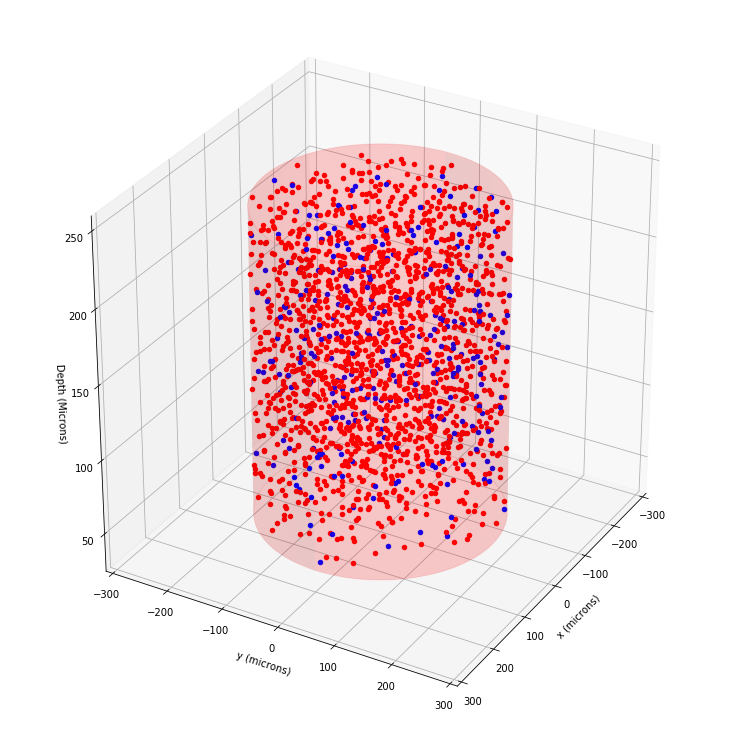

In [8]:
#Plot a layer from the cortex column
layer_id = 1
fig= plt.figure(figsize=(10,10))
ax = Axes3D(fig, azim=30, elev=30)

column.plotLayer(layer_id, ax=ax)

Layers: ['L1', 'L2', 'L3', 'L4', 'L5A', 'L5B', 'L6A', 'L6B']
Radii: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Heights: [39.13128829610274, 205.44568697650476, 240.32640359718422, 196.77792103427794, 232.03066104707847, 272.7547119133928, 284.0068000525321, 193.0461026745287]


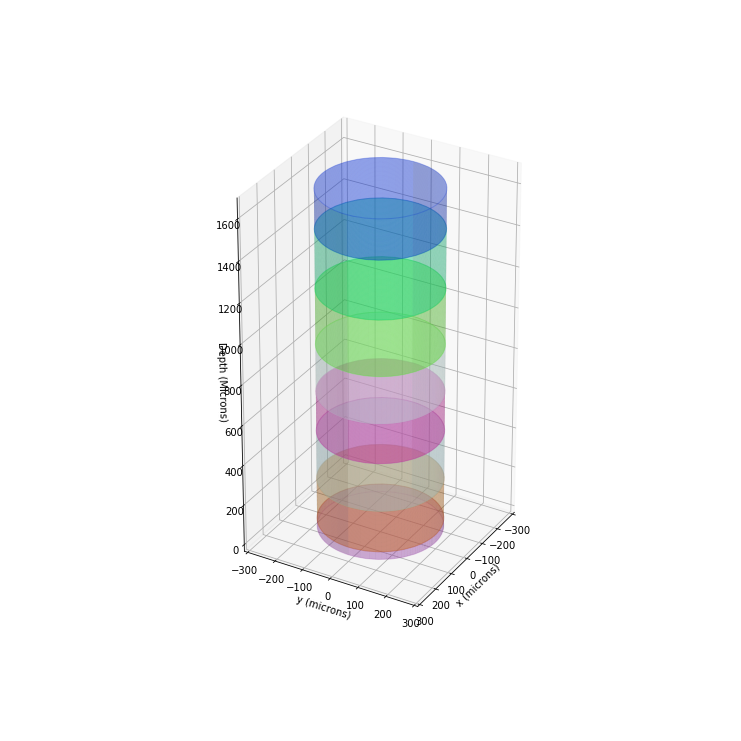

In [9]:
#Plot the entire column without any neurons to see the layer shapes
fig=plt.figure(figsize=(10,10))
ax = Axes3D(fig, azim=30, elev=30)

column.plotColumn(plot_neurons=False, ax=ax)

Layers: ['L1', 'L2', 'L3', 'L4', 'L5A', 'L5B', 'L6A', 'L6B']
Radii: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Heights: [39.13128829610274, 205.44568697650476, 240.32640359718422, 196.77792103427794, 232.03066104707847, 272.7547119133928, 284.0068000525321, 193.0461026745287]
Total Neurons: {'L6B': 915, 'L5B': 2055, 'L5A': 1860, 'L4': 3149, 'L2': 1924, 'L3': 2889, 'L1': 39, 'L6A': 3274}
IN Neurons: {'L6B': 78, 'L5B': 333, 'L5A': 460, 'L4': 240, 'L2': 293, 'L3': 232, 'L1': 33, 'L6A': 287}
EX Neurons: {'L6B': 837, 'L5B': 1722, 'L5A': 1400, 'L4': 2909, 'L2': 1631, 'L3': 2657, 'L1': 6, 'L6A': 2987}


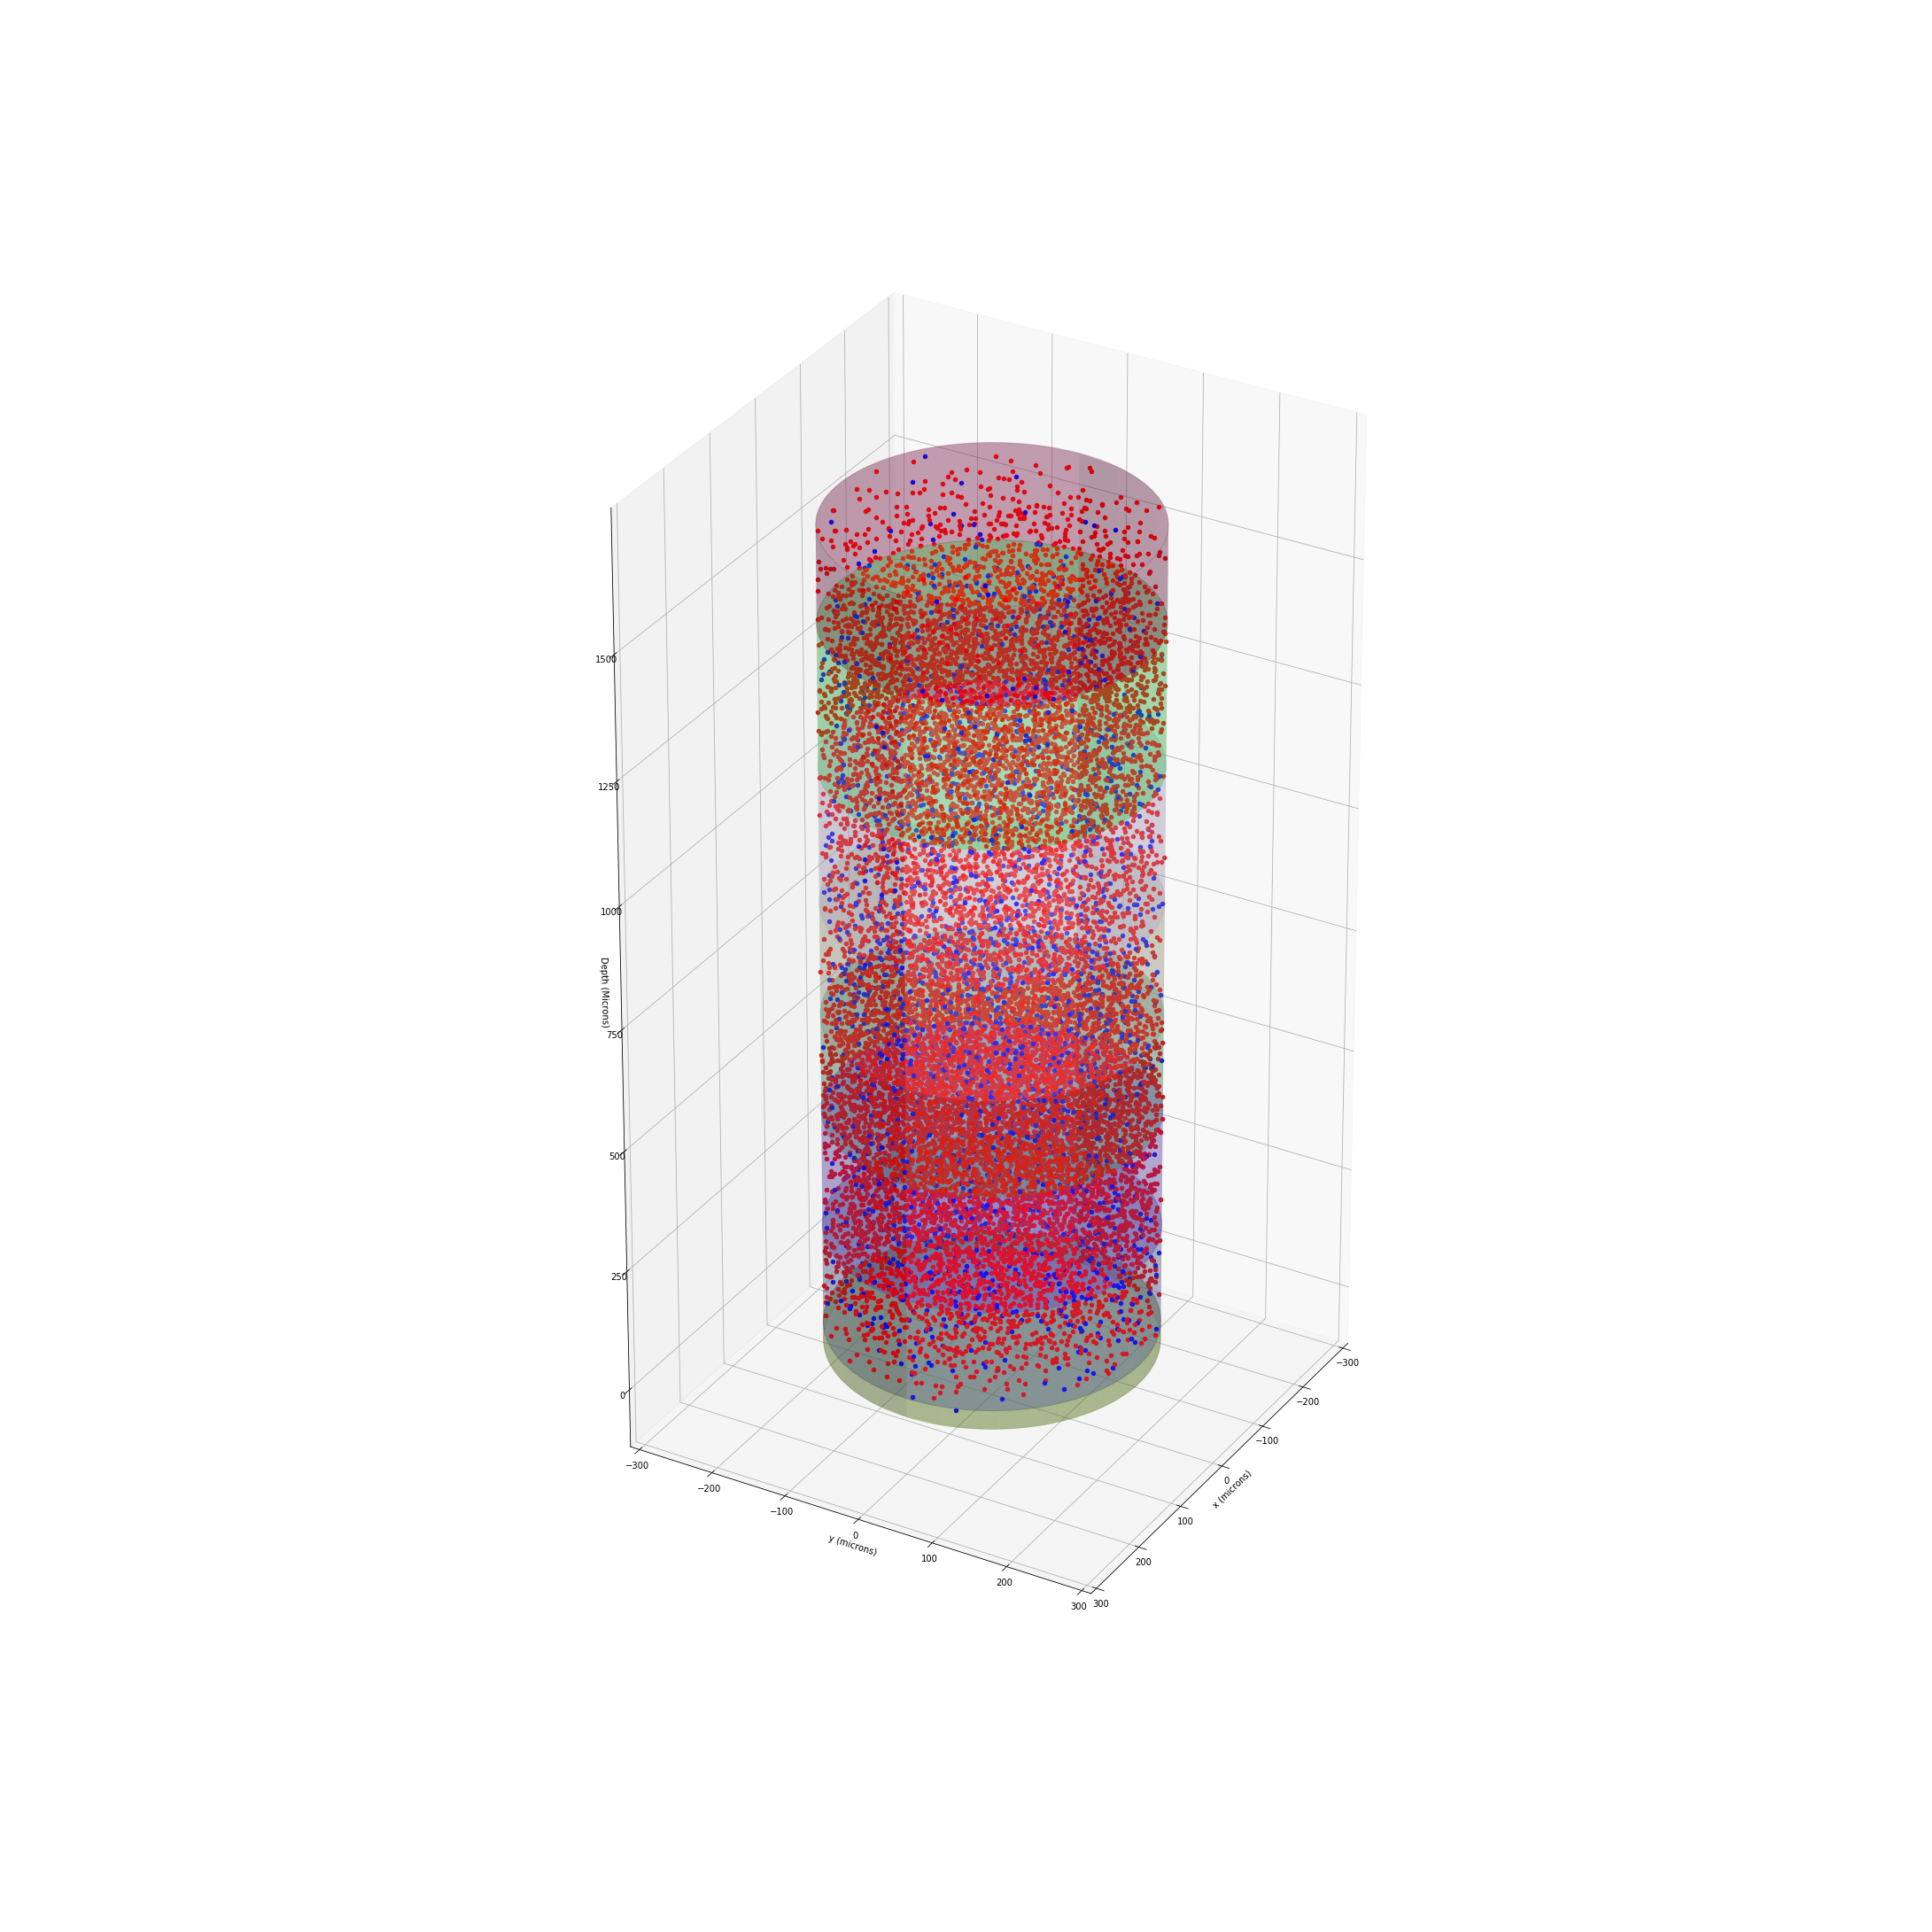

In [10]:
#Can plot the entire column with all neurons included (pretty slow, lots of neurons to be scattered)
fig=plt.figure(figsize=(30,30))
ax = Axes3D(fig, azim=30, elev=30)

column.plotColumn(plot_neurons=True, ax=ax)

## 2. Creating and using a Probe object (Neuropixels subclass)

Layers: ['L1', 'L2', 'L3', 'L4', 'L5A', 'L5B', 'L6A', 'L6B']
Radii: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Heights: [39.13128829610274, 205.44568697650476, 240.32640359718422, 196.77792103427794, 232.03066104707847, 272.7547119133928, 284.0068000525321, 193.0461026745287]


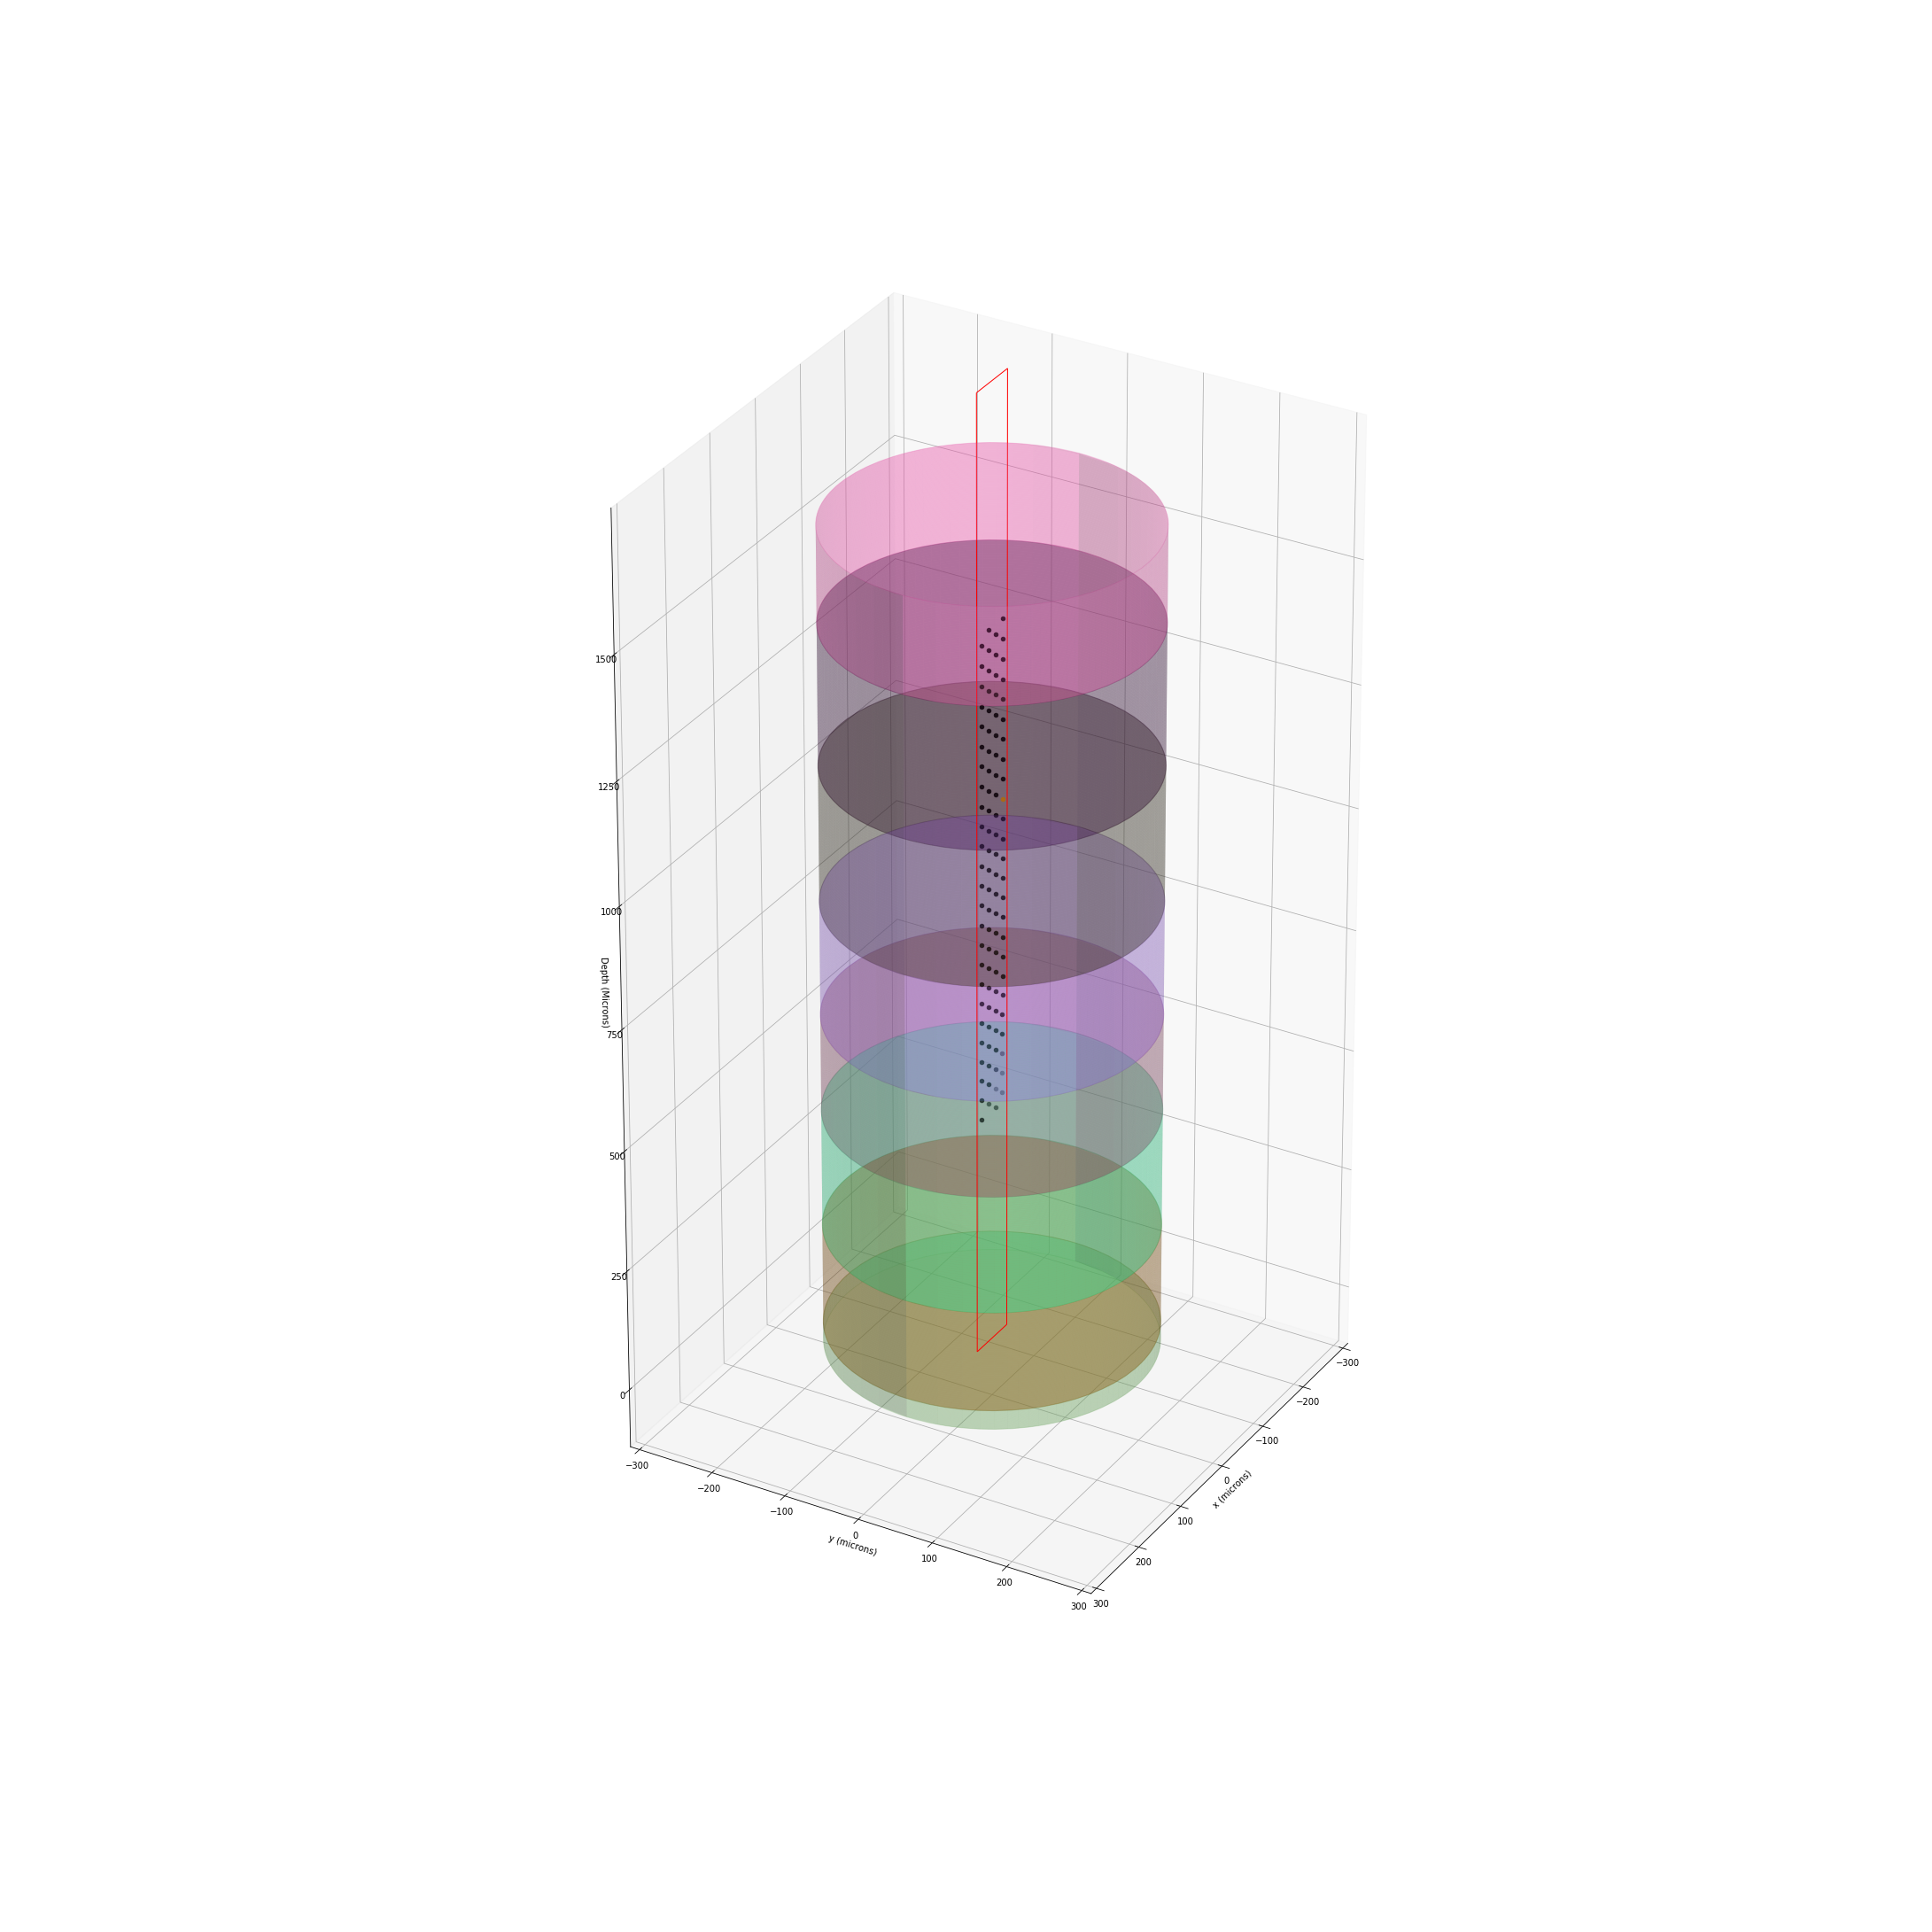

In [19]:
fig=plt.figure(figsize=(30,30))
ax = Axes3D(fig, azim=30, elev=30)

#Import a probe object that is instantiated with a specified number of channels
from probes.PremadeProbes import NeuropixelsProbe
probe = NeuropixelsProbe(num_channels = 192)

#Draw the probe, black channels are recording, orange channels are reference (can exclude channel ids from drawing)
excluded_channel_ids = range(46) + range(146, 192)
probe.draw(ax=ax, excluded_channel_ids=excluded_channel_ids)

#Plot the layers of the column to see how the probe interacts with the cortical region
column.plotColumn(plot_neurons=False, ax=ax)

Layers: ['L1', 'L2', 'L3', 'L4', 'L5A', 'L5B', 'L6A', 'L6B']
Radii: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Heights: [39.13128829610274, 205.44568697650476, 240.32640359718422, 196.77792103427794, 232.03066104707847, 272.7547119133928, 284.0068000525321, 193.0461026745287]


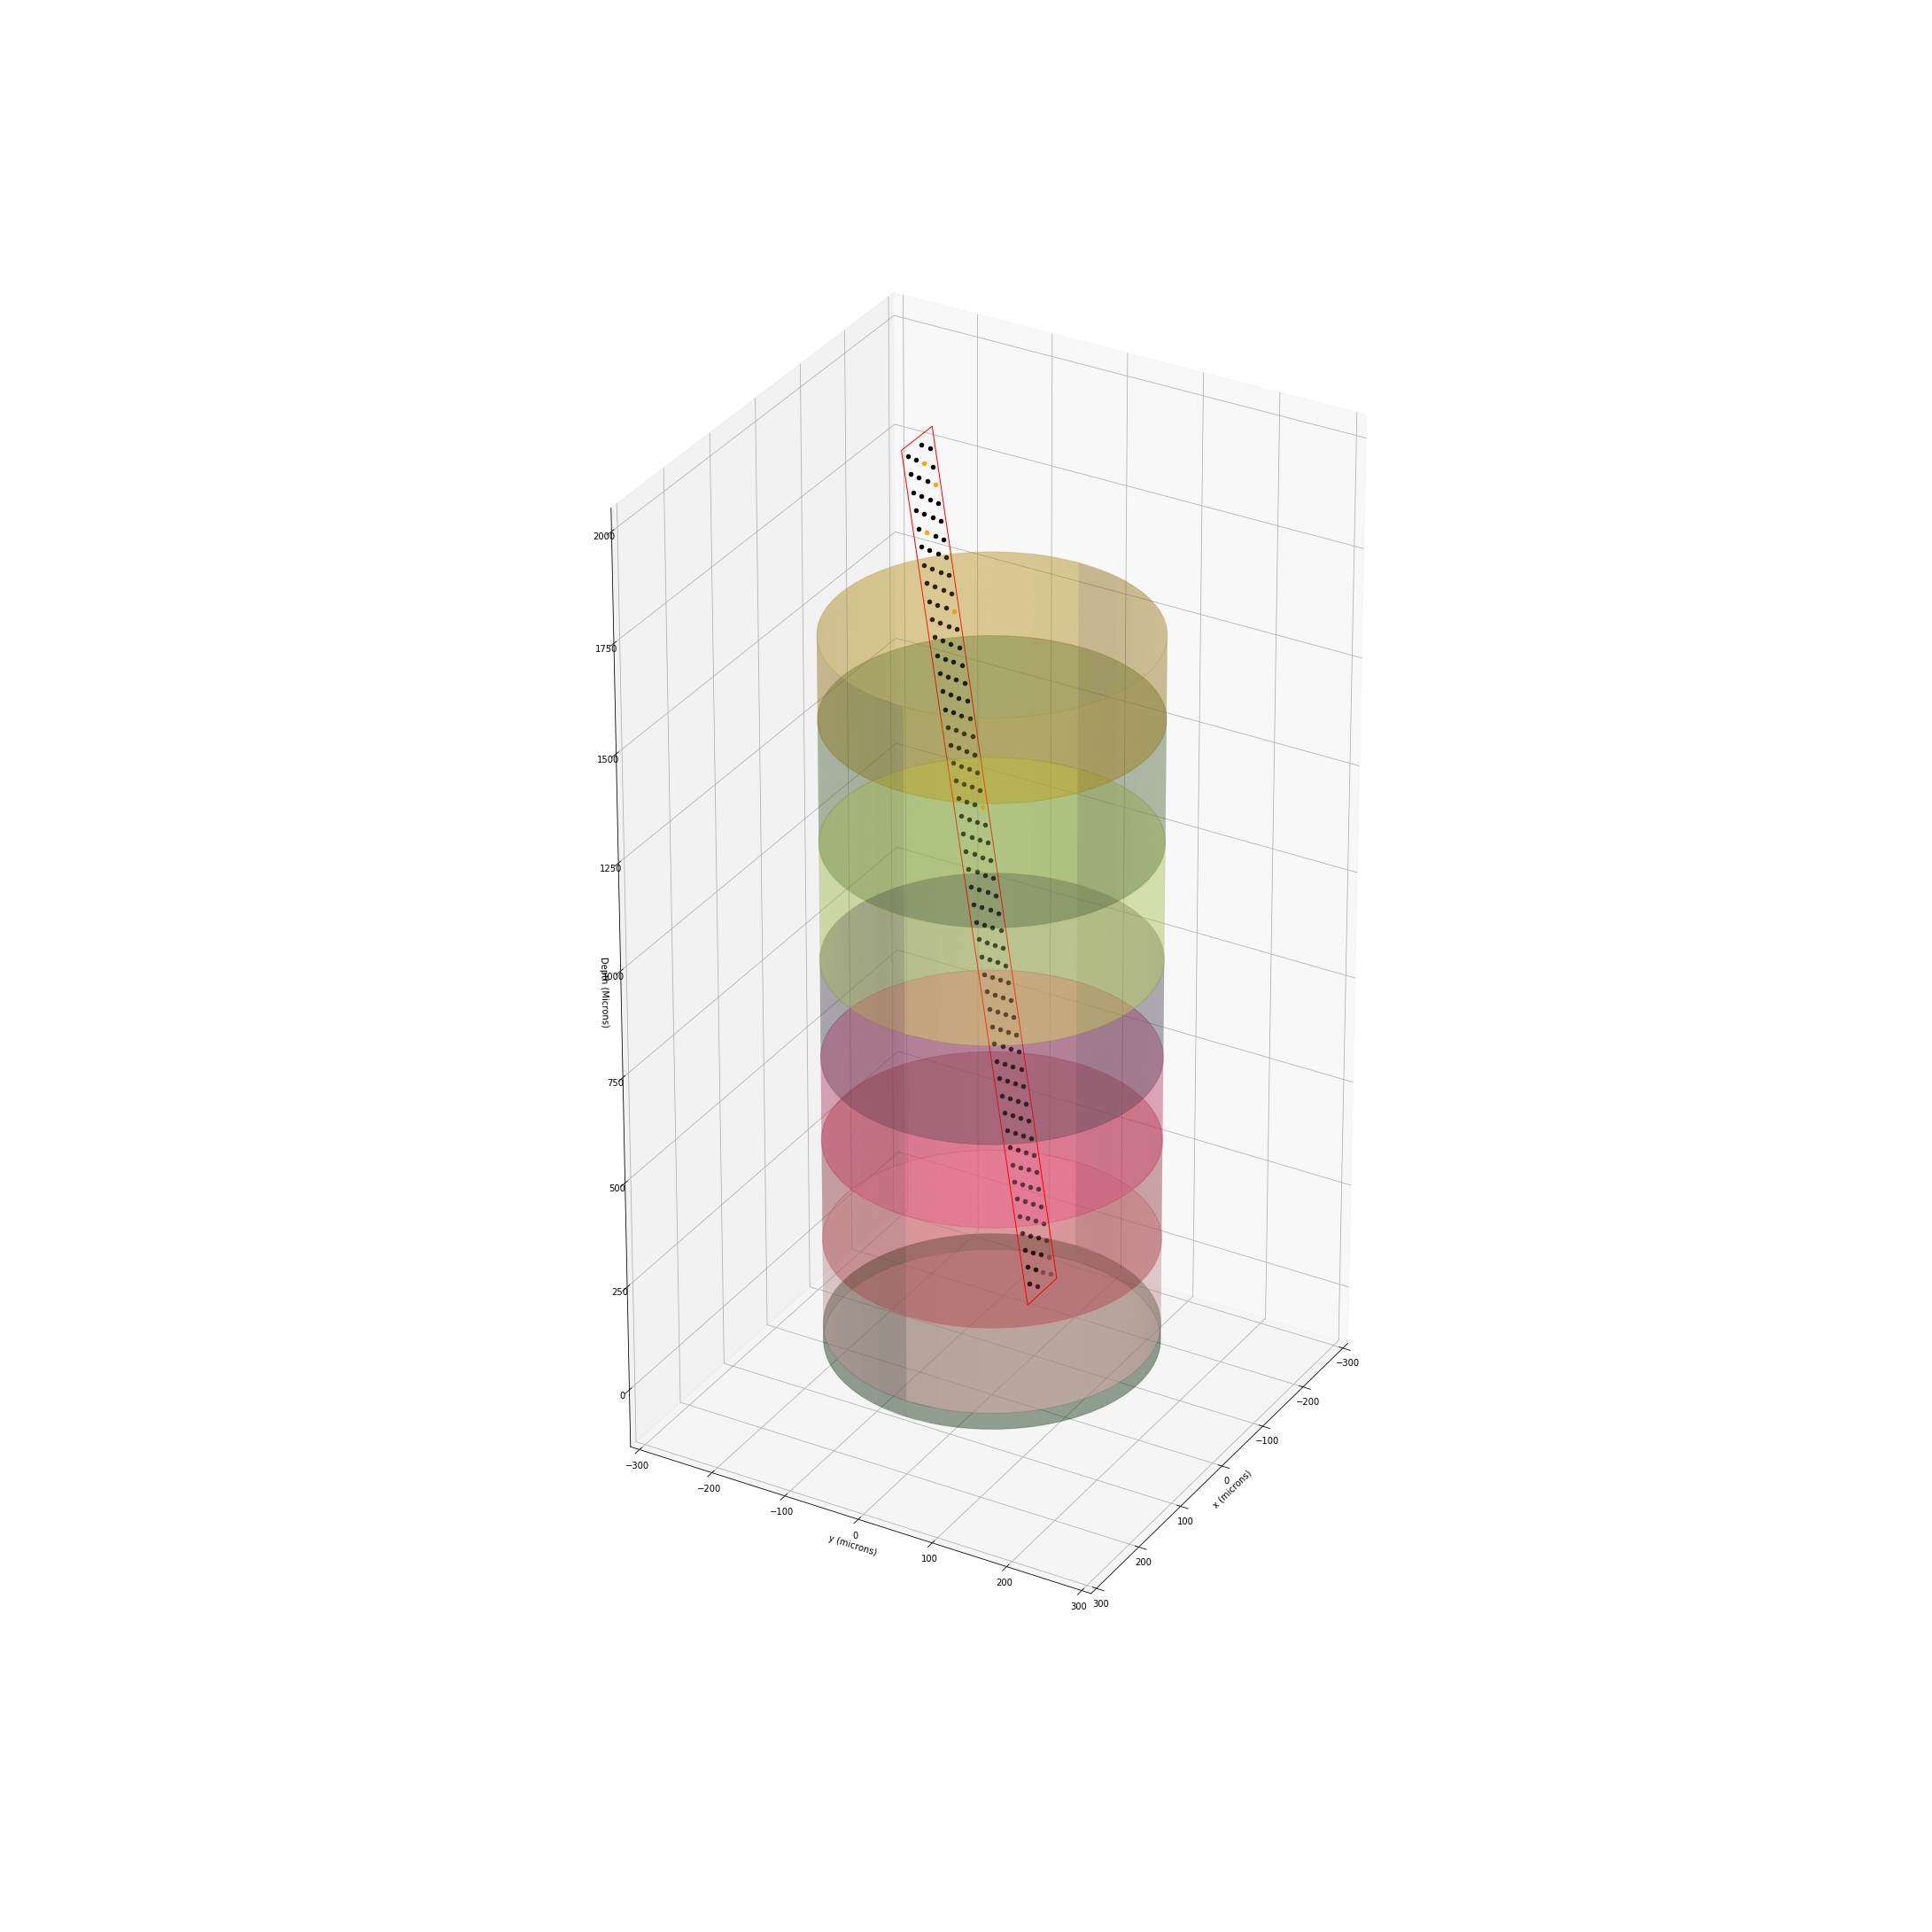

In [20]:
fig=plt.figure(figsize=(30,30))
ax = Axes3D(fig, azim=30, elev=30)

#rotate the probe around the given axis counterclockwise with a given angle (radians). Plotting is optional
axis = np.asarray([1, 0, 0])
theta = math.pi/36 #radians
probe.rotate(theta, axis, ax=ax, plot=False)

#shift the probe in the direction of a given axis with a given distance. Plotting is optional
axis = np.asarray([1, 0, 0])
dist = -120 #microns
probe.shift(dist, axis, ax=ax, plot=True)


column.plotColumn(plot_neurons=False, ax=ax)

Num neurons: 1928
Layers: ['L1', 'L2', 'L3', 'L4', 'L5A', 'L5B', 'L6A', 'L6B']
Radii: [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Heights: [39.13128829610274, 205.44568697650476, 240.32640359718422, 196.77792103427794, 232.03066104707847, 272.7547119133928, 284.0068000525321, 193.0461026745287]
Total Neurons: {'L6B': 31, 'L5B': 345, 'L5A': 330, 'L4': 576, 'L2': 0, 'L3': 167, 'L1': 0, 'L6A': 479}
IN Neurons: {'L6B': 4, 'L5B': 48, 'L5A': 83, 'L4': 51, 'L2': 0, 'L3': 15, 'L1': 0, 'L6A': 47}
EX Neurons: {'L6B': 27, 'L5B': 297, 'L5A': 247, 'L4': 525, 'L2': 0, 'L3': 152, 'L1': 0, 'L6A': 432}


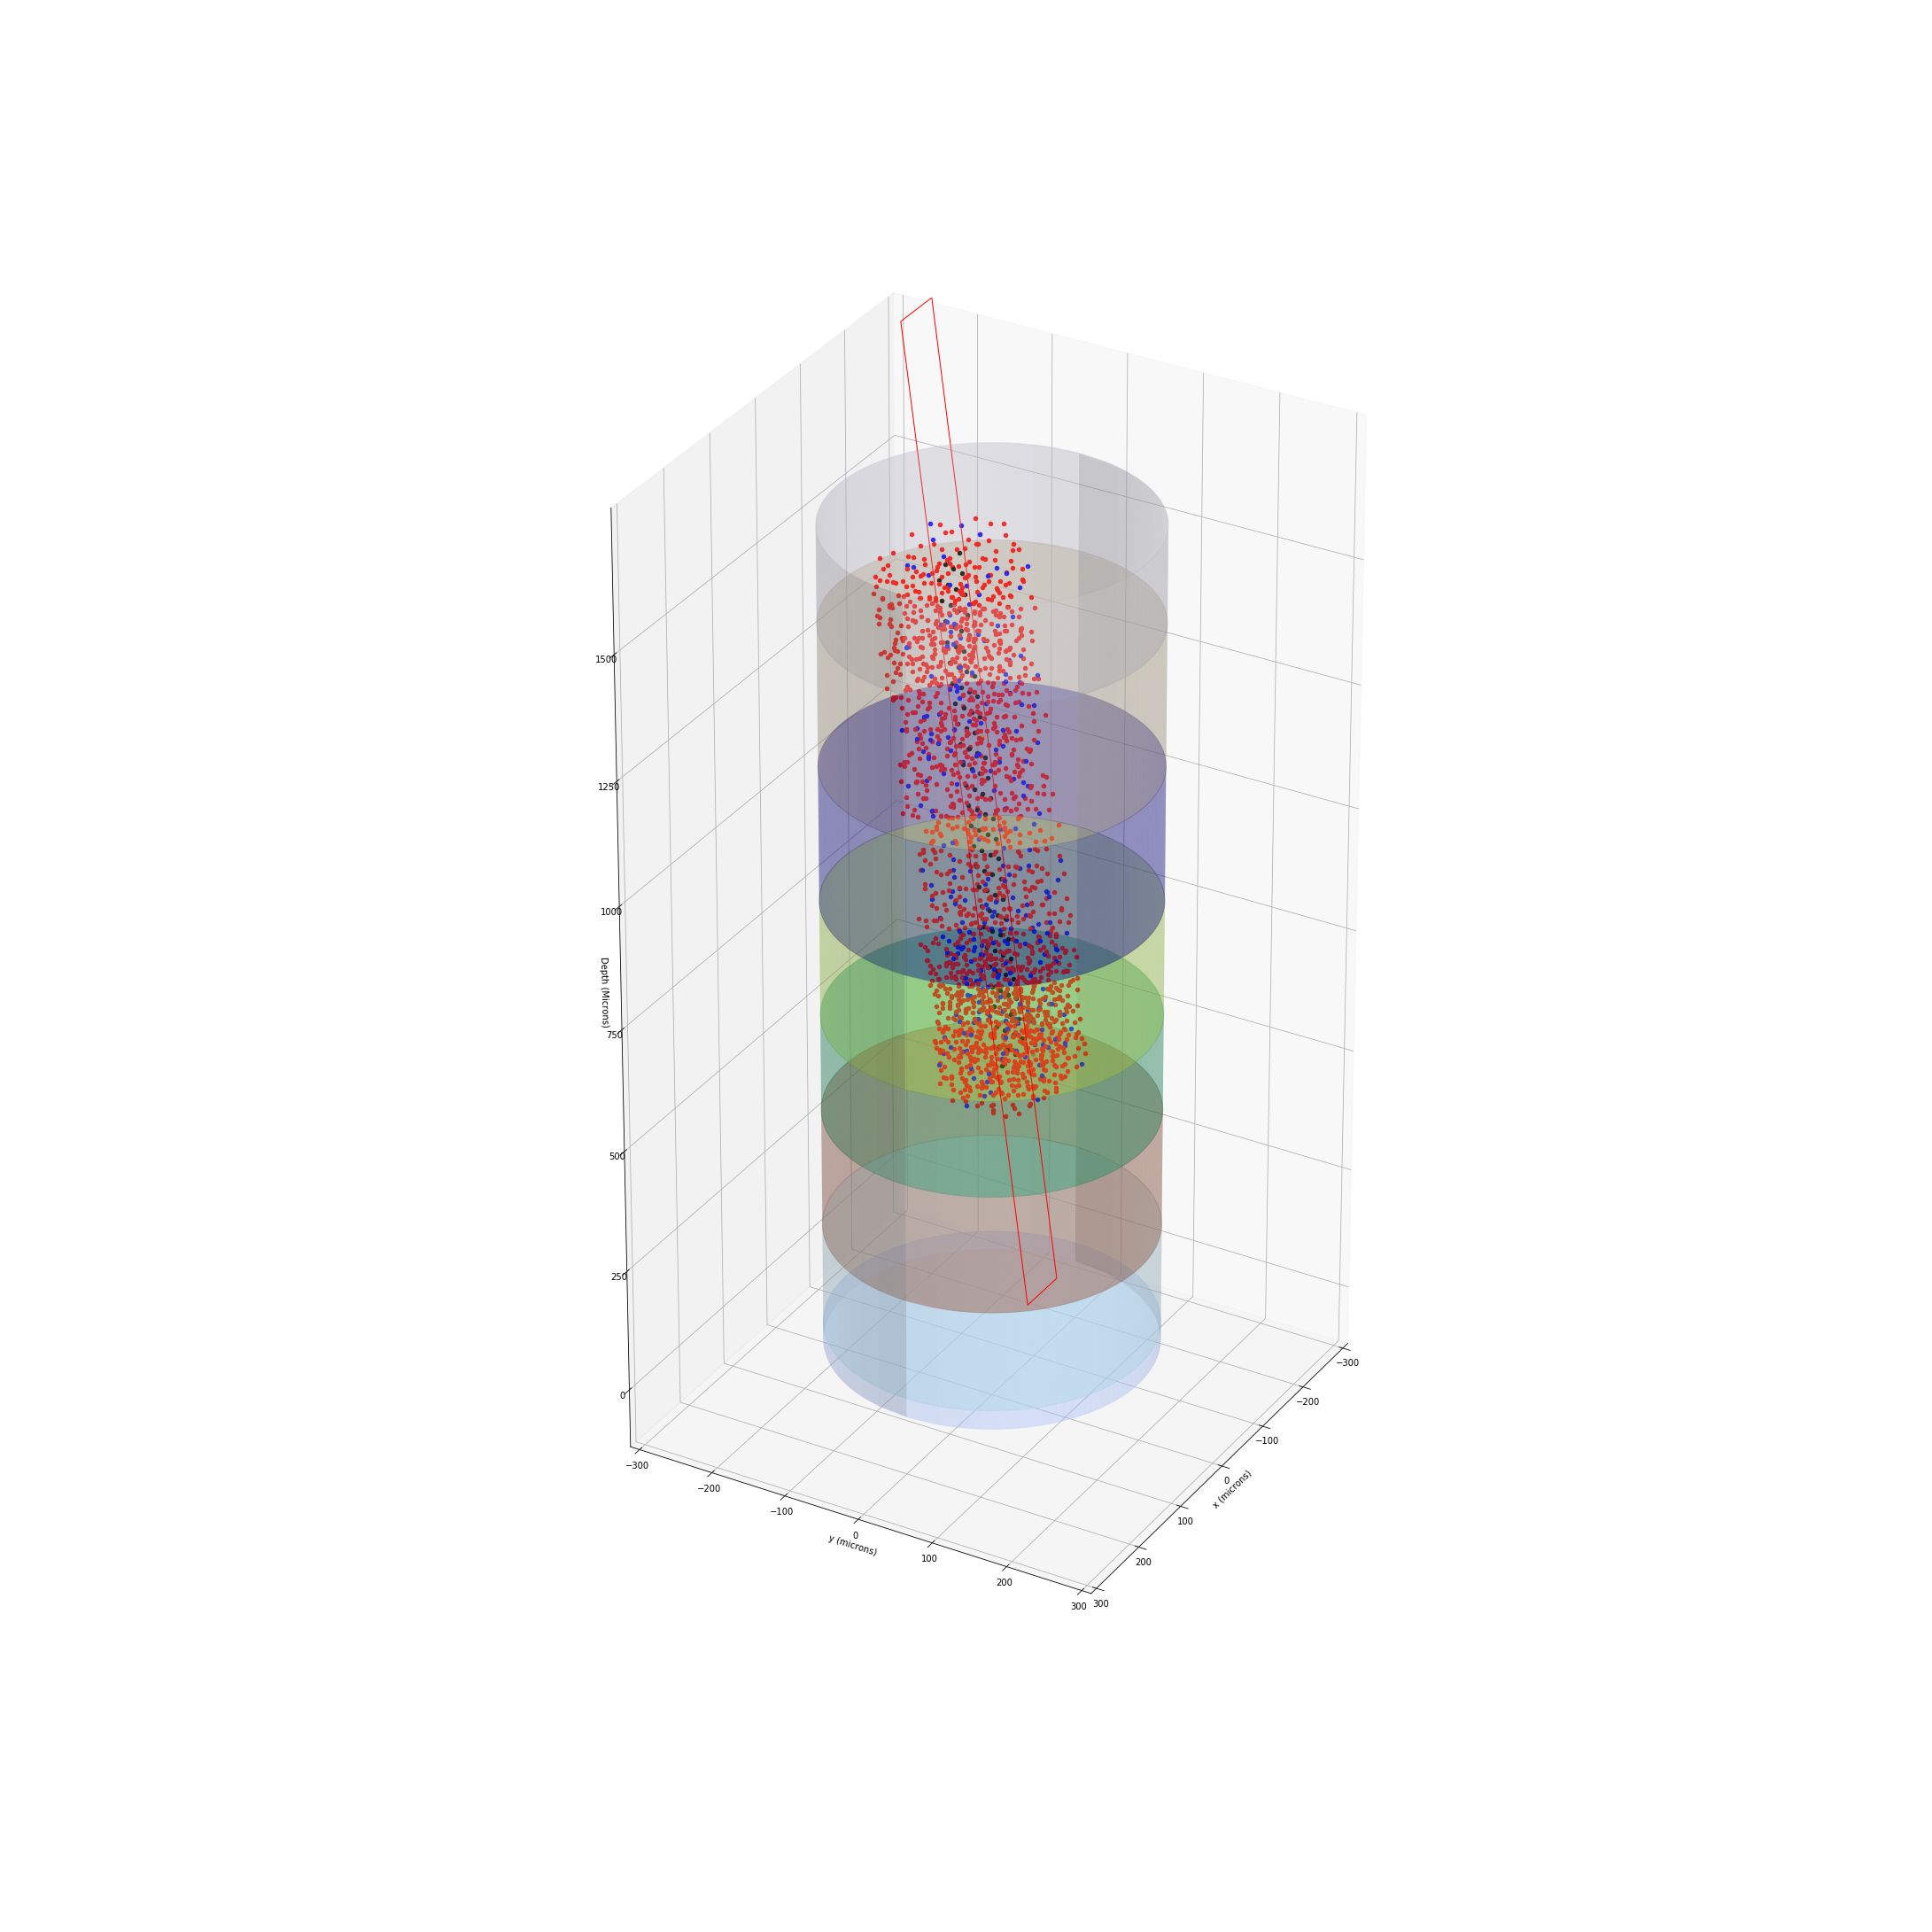

In [21]:
#Get all neurons within a radius of any channel on the array (can exclude channels)
close_neuron_df = probe.getNeuronsRadius(column.getNeurons(), radius=80.0, excluded_channel_ids=excluded_channel_ids)
print("Num neurons: " + str(close_neuron_df.shape[0]))
#Can plot the column with all neurons in the radius
fig=plt.figure(figsize=(30,30))
ax = Axes3D(fig, azim=30, elev=30)
probe.draw(ax, excluded_channel_ids=excluded_channel_ids)

column.plotColumn(close_neuron_df, plot_neurons=True, ax=ax)

## 3. All data structures needed for simulating an extracellular recording

In [23]:
#All neurons for the recording
print(close_neuron_df)

#Can get all neuron positions in numpy array
close_neuron_pos = np.asarray(list(close_neuron_df['pos'].copy()))
print(close_neuron_pos.shape)


#All channels on the probe (you can return all non-excluded channel ids)
probe_channels = probe.getChannels(excluded_channel_ids=excluded_channel_ids)
print(probe_channels)

#Can get all channel positions in numpy array
close_channels_pos = np.asarray(list(probe_channels['pos'].copy()))
print(close_channels_pos.shape)

          id                                                pos type layer
8192    8192  [-93.98840513377299, -107.36682380103184, 879....   IN   L5A
8194    8194  [-144.42418405830742, -63.86557777391475, 736....   IN   L5A
8199    8199  [-88.80147116900427, -102.34995732428911, 848....   IN   L5A
13656  13656  [-149.06460379287503, -60.945032882812285, 146...   EX   L6A
8213    8213  [-86.06720921414873, 6.292134943913116, 787.74...   IN   L5A
8214    8214  [-148.97735573196002, -116.51529542731679, 809...   IN   L5A
13657  13657  [-68.902858326111, -94.8061999012089, 1353.529...   EX   L6A
12292  12292  [-99.19903676674427, -123.16084557670287, 1336...   EX   L6A
8222    8222  [-117.38082298628495, -126.62159149183019, 683...   IN   L5A
8229    8229  [-25.164594794291087, -59.00363115701896, 805....   IN   L5A
8245    8245  [-144.55881864454275, -93.41862490081661, 795....   IN   L5A
8247    8247  [-38.867597336043346, -77.93725428539447, 857....   IN   L5A
8249    8249  [-161.42746